# Analyse des données du CAC40

# Préparation de l'espace de travail

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import des données

In [2]:
CAC = pd.read_csv(r'C:\Users\HP\Documents\ENSAE 2A\Statapp\CAC.csv', sep=';', decimal=',')

Mise en forme des données

In [3]:
CAC['DATES']= pd.to_datetime(CAC['DATES'])
cols = CAC.columns.drop('DATES')
CAC[cols] = CAC[cols].apply(pd.to_numeric)

In [4]:
print(CAC)

          DATES  OR FP Equity  DG FP Equity  URW NA Equity  FP FP Equity  \
0    2010-10-23           NaN           NaN            NaN           NaN   
1    2010-10-24           NaN           NaN            NaN           NaN   
2    2010-10-25     86.790000     39.350000         152.00     39.050000   
3    2010-10-26     86.550000     39.015000         153.05     39.125000   
4    2010-10-27     85.250000     38.610000         152.05     38.600000   
...         ...           ...           ...            ...           ...   
3650 2020-10-20    290.600000     74.260000          41.50     28.230000   
3651 2020-10-21    286.800000     71.900000          39.38     27.775000   
3652 2020-10-22    285.300000     71.820000          37.86     27.620000   
3653 2020-10-23    288.799988     72.800003          38.57     28.110001   
3654        NaT           NaN           NaN            NaN           NaN   

      DSY FP Equity  AI FP Equity  CS FP Equity  BNP FP Equity  BN FP Equity  \
0      

Suppression des données manquantes (weekends, jours fériés etc) et suppression du dernier actif

In [5]:
del CAC['WLN FP Equity']

In [6]:
CAC2=CAC.copy()
del CAC2['DATES']
for i in range(len(CAC.index)):
    if CAC2.iloc[i].isnull().values.all()==True:
        CAC=CAC.drop(index=i)

Remplissage des données anormales

In [7]:
CAC=CAC.fillna(method='ffill')

Calcul des rendements

In [8]:
cols=CAC.columns.drop('DATES')
returns=CAC.copy()
returns[cols] = returns[cols].apply(lambda x: (x / (x.shift(1)))-1)

In [9]:
returns=returns.iloc[1:]

Graphiques

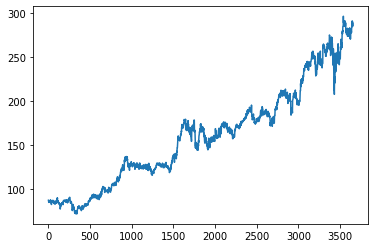

In [10]:
CAC['OR FP Equity'].plot()

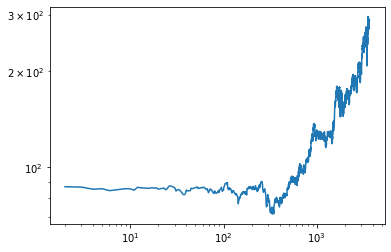

In [11]:
CAC['OR FP Equity'].plot(loglog=True)

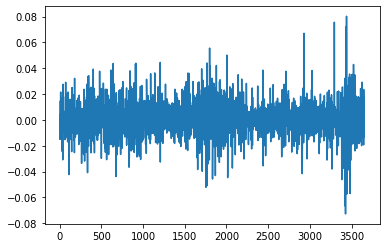

In [12]:
returns['OR FP Equity'].plot()

# 0) Faits stylisés

Absence d'autocorrélation linéaire:

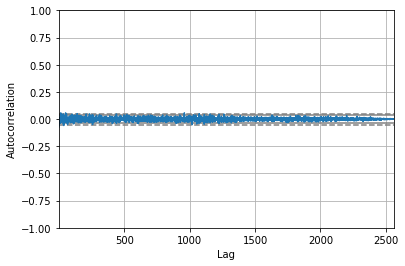

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(returns['OR FP Equity'])

La corrélation linéaire entre les rendements d'un même actif dans le temps est quasi-nulle.

Normalité:

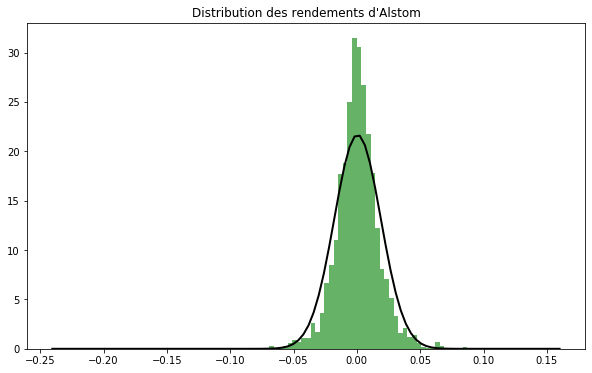

kurtosis 13.777464095246263
test de shapiro: (0.9127706289291382, 4.800222371360637e-36)


In [23]:
from scipy.stats import norm

# Génération de la loi normale:
data=returns['ATO FP Equity']
mu, std = norm.fit(data)

plt.figure(figsize=(10,6))
# Histogramme:
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Plot de la densité:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution des rendements d'Alstom"
plt.title(title)

plt.show()

#kurtosis
from scipy.stats import kurtosis 
print('kurtosis', kurtosis(data))

#Shapiro-Wilk test:
from scipy.stats import shapiro
print('test de shapiro:', shapiro(data))


Le test de shapiro rejette l'hypothèse de normalité: la distribution des rendements présente une acuité plus élevée que la gaussienne associée (kurtosis de 13.78, alors que le kurtosis d'une gaussienne est égal à 3).

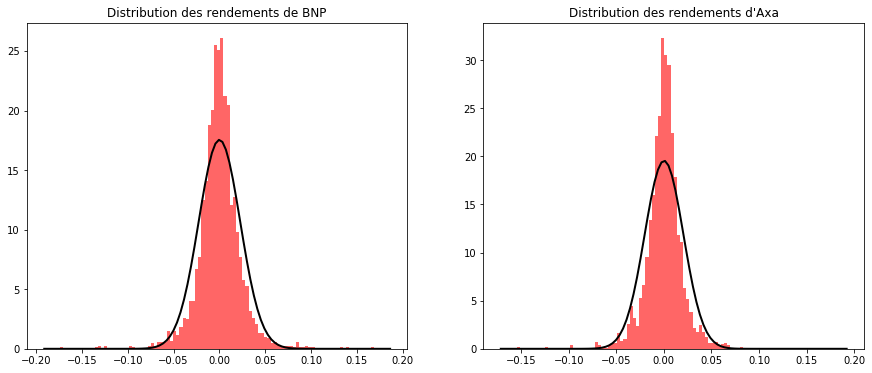

In [22]:
#Même chose avec les rendements de les actifs BNP et AXA


data=returns['BNP FP Equity']
mu, std = norm.fit(data)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(data, bins=100, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution des rendements de BNP"
plt.title(title)
data=returns['CS FP Equity']
mu, std = norm.fit(data)

plt.subplot(1, 2, 2)
plt.hist(data, bins=100, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution des rendements d'Axa"
plt.title(title)


plt.show()

Volatility clustering:

(-0.2, 0.2)

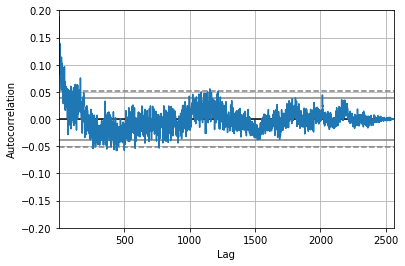

In [26]:
#autocorrélation des rendements en valeur absolue:
ax=autocorrelation_plot(abs(returns['OR FP Equity']))
ax.set_ylim([-0.2, 0.2])

La volatilité des rendements d'un actif présente elle une autocorrélation sur le long terme. La fonction d'autocorrélation décroit ainsi lentement vers zéro.

Leverage effect

In [27]:
#Autocorrélation de la valeur absolue des rendements et des rendements simples
import math as mt
def autocorr(x):
    result = np.correlate(np.square(x), x, mode='full')
    return result[mt.floor(result.size/2):]

Text(0.5, 1.0, 'Autocorrélation des rendements simples avec les rendments au carré pour FP FP Equity')

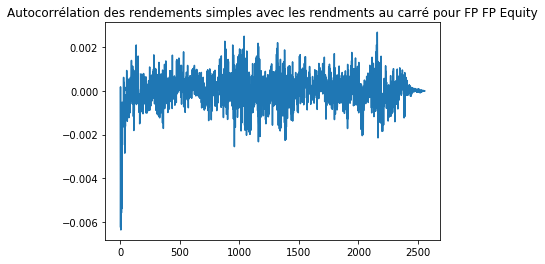

In [29]:
plt.plot(autocorr(returns['FP FP Equity']))
plt.title("Autocorrélation des rendements simples avec les rendments au carré pour FP FP Equity")

L'autocorrélation tend à être négative, ce qui illustre que la volatilité s'observe surtout lorsque les rendements sont négatifs (lorsque les cours baissent). C'est le leverage effect.

# I) Implémentation de Markovitz et frontière efficiente théorique de référence